Activists have asserted that there is a strong gender bias in student evaluations of professors, with 
male professors enjoying a boost in rating from this bias. While this has been celebrated by ideologues, 
skeptics have pointed out that this research is of technically poor quality, either due to a low sample 
size – as small as n = 1 (Mitchell & Martin, 2018), failure to control for confounders such as teaching 
experience (Centra & Gaubatz, 2000) or obvious p-hacking (MacNell et al., 2015). We would like you to 
answer the question whether there is evidence of a pro-male gender bias in this dataset.  
Hint: A significance test is probably required.


The columns represent the following information, in order:
1. Average Rating (the arithmetic mean of all individual quality ratings of this professor)
2. Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)
3. Number of ratings (simply the total number of ratings these averages are based on)
4. Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)
5. The proportion of students that said they would take the class again
6. The number of ratings coming from online classes
7. Male gender (Boolean – 1: determined with high confidence that professor is male)
8. Female (Boolean – 1: determined with high confidence that professor is female)


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
seed = 10676128

Q7. Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns

In [2]:
df_capstone = pd.read_csv('./rmpCapstoneNum.csv', header=None)
df_capstone.columns = ['Average Rating', 'Average Difficulty', 'Number of ratings', 'Received a pepper', 
                       'Proportion of students that said they would take the class again', 
                       'Number of ratings coming from online classes', 'Male Professor', 'Female Professor']

In [3]:
df_capstone.isna().sum()

Average Rating                                                      19889
Average Difficulty                                                  19889
Number of ratings                                                   19889
Received a pepper                                                   19889
Proportion of students that said they would take the class again    77733
Number of ratings coming from online classes                        19889
Male Professor                                                          0
Female Professor                                                        0
dtype: int64

In [4]:
df_capstone_na_dropped=df_capstone.drop(columns=['Proportion of students that said they would take the class again']).dropna()

In [5]:
df_capstone_na_dropped['Proportion of online class ratings'] = df_capstone_na_dropped['Number of ratings coming from online classes'].div(df_capstone_na_dropped['Number of ratings'])

In [6]:
df_capstone_na_dropped

,Average Rating,Average Difficulty,Number of ratings,Received a pepper,Number of ratings coming from online classes,Male Professor,Female Professor,Proportion of online class ratings
0,5.0,1.5,2.0,0.0,0.0,0,1,0.000000
2,3.2,3.0,4.0,0.0,0.0,1,0,0.000000
3,3.6,3.5,10.0,1.0,0.0,0,0,0.000000
4,1.0,5.0,1.0,0.0,0.0,0,0,0.000000
5,3.5,3.3,22.0,0.0,7.0,1,0,0.318182
...,...,...,...,...,...,...,...,...
89885,3.9,3.8,4.0,1.0,0.0,0,1,0.000000
89888,2.5,2.5,2.0,0.0,0.0,0,0,0.000000
89889,4.5,2.0,2.0,0.0,0.0,1,0,0.000000
89890,5.0,1.7,6.0,1.0,2.0,1,0,0.333333


In [7]:
df_capstone_greater_than_10=df_capstone_na_dropped[df_capstone_na_dropped['Number of ratings'] >= 10]

In [8]:
df_capstone_greater_than_10

,Average Rating,Average Difficulty,Number of ratings,Received a pepper,Number of ratings coming from online classes,Male Professor,Female Professor,Proportion of online class ratings
3,3.6,3.5,10.0,1.0,0.0,0,0,0.000000
5,3.5,3.3,22.0,0.0,7.0,1,0,0.318182
21,2.6,4.1,10.0,0.0,0.0,1,0,0.000000
25,4.3,3.3,16.0,1.0,0.0,0,1,0.000000
39,3.5,3.2,20.0,1.0,0.0,1,0,0.000000
...,...,...,...,...,...,...,...,...
89841,4.2,3.8,11.0,0.0,0.0,0,1,0.000000
89855,4.0,1.9,11.0,1.0,0.0,1,0,0.000000
89866,4.4,3.6,14.0,1.0,0.0,0,1,0.000000
89875,2.8,2.9,16.0,0.0,13.0,0,0,0.812500


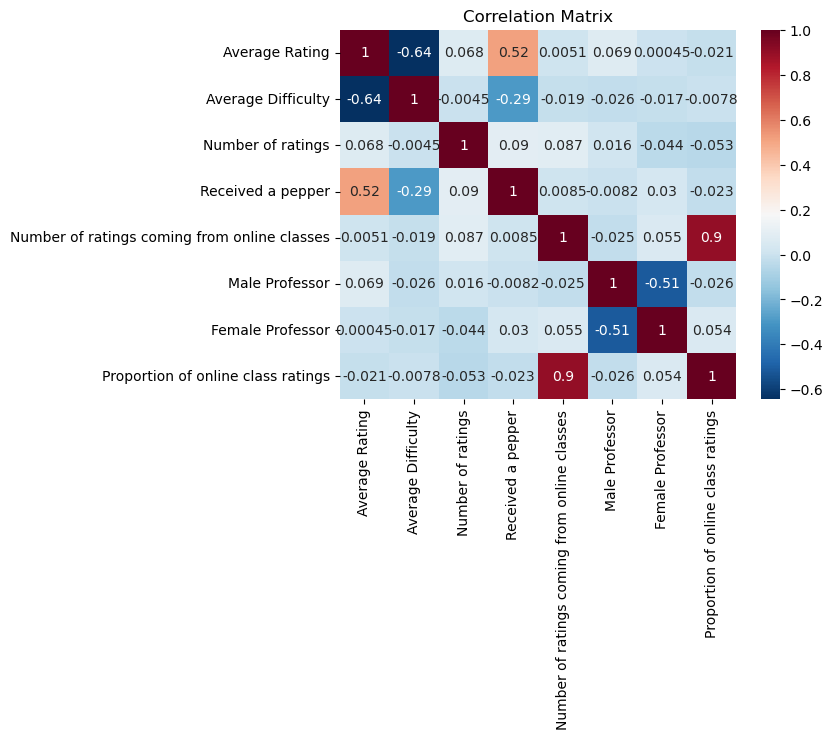

In [9]:
correlation_matrix = df_capstone_greater_than_10.corr()

sns.heatmap(correlation_matrix,cmap = "RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.show()

In [10]:
df_capstone_dropped_final=df_capstone_greater_than_10.drop(columns=['Number of ratings coming from online classes'])

In [11]:
df_capstone_dropped_final=df_capstone_dropped_final[(df_capstone_dropped_final['Male Professor']==1) & (df_capstone_dropped_final['Female Professor']==0) | (df_capstone_dropped_final['Male Professor']==0) & (df_capstone_dropped_final['Female Professor']==1)]

In [12]:
df_capstone_dropped_final=df_capstone_dropped_final.drop(columns=['Male Professor'])

In [13]:
df_capstone_dropped_final

,Average Rating,Average Difficulty,Number of ratings,Received a pepper,Female Professor,Proportion of online class ratings
5,3.5,3.3,22.0,0.0,0,0.318182
21,2.6,4.1,10.0,0.0,0,0.000000
25,4.3,3.3,16.0,1.0,1,0.000000
39,3.5,3.2,20.0,1.0,0,0.000000
40,1.8,3.8,15.0,0.0,1,0.066667
...,...,...,...,...,...,...
89810,3.4,3.4,14.0,0.0,0,0.357143
89841,4.2,3.8,11.0,0.0,1,0.000000
89855,4.0,1.9,11.0,1.0,0,0.000000
89866,4.4,3.6,14.0,1.0,1,0.000000


In [14]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def normal_regression(X_train, y_train):
    return np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

def ridge_regression(X_train, y_train, alpha):
    n_features = X_train.shape[1]
    identity = np.eye(n_features)
    identity[0, 0] = 0  
    return np.linalg.inv(X_train.T @ X_train + alpha * identity) @ X_train.T @ y_train

def lasso_regression(X_train, y_train, alpha, max_iter=1000, tol=1e-4):
    m, n = X_train.shape
    beta = np.zeros(n)
    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(n):
            residual = y_train - X_train @ beta + X_train[:, j] * beta[j]
            rho = X_train[:, j].T @ residual
            if j == 0:  
                beta[j] = rho / (X_train[:, j].T @ X_train[:, j])
            else:
                beta[j] = np.sign(rho) * max(0, abs(rho) - alpha) / (X_train[:, j].T @ X_train[:, j])
        if np.max(np.abs(beta - beta_old)) < tol:
            break
    return beta

In [15]:
def getKFresults(X,y,alphas=np.array([0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,20,100,1000,100000])):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    results = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
        X_val_scaled = np.hstack((np.ones((X_val_scaled.shape[0], 1)), X_val_scaled))

        # Normal Regression
        beta_normal = normal_regression(X_train_scaled, y_train)
        y_pred_normal = X_val_scaled @ beta_normal
        rmse_normal = compute_rmse(y_val, y_pred_normal)
        r2_normal = compute_r2(y_val, y_pred_normal)
        
        # Ridge Regression
        for alpha in alphas:
            beta_ridge = ridge_regression(X_train_scaled, y_train, alpha)
            y_pred_ridge = X_val_scaled @ beta_ridge
            rmse_ridge = compute_rmse(y_val, y_pred_ridge)
            r2_ridge = compute_r2(y_val, y_pred_ridge)
            results.append(('Ridge', alpha, rmse_ridge, r2_ridge))
        
        # Lasso Regression
        for alpha in alphas:
            beta_lasso = lasso_regression(X_train_scaled, y_train, alpha)
            y_pred_lasso = X_val_scaled @ beta_lasso
            rmse_lasso = compute_rmse(y_val, y_pred_lasso)
            r2_lasso = compute_r2(y_val, y_pred_lasso)
            results.append(('Lasso', alpha, rmse_lasso, r2_lasso))
        
        results.append(('Normal', None, rmse_normal, r2_normal))
    return results

In [16]:
def getbetas(X_train,y_train,X_test,y_test):
    results=[]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

    # Normal Regression
    beta_normal = normal_regression(X_train_scaled, y_train)
    y_pred_normal = X_test_scaled @ beta_normal
    rmse_normal = compute_rmse(y_test, y_pred_normal)
    r2_normal = compute_r2(y_test, y_pred_normal)
    results.append(('Normal',beta_normal, rmse_normal, r2_normal))
    return beta_normal,rmse_normal,r2_normal



In [17]:
def getbetaslasso(X_train,y_train,X_test,y_test,alpha=10):
    results=[]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
    X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

    # Normal Regression
    beta_lasso = lasso_regression(X_train_scaled, y_train, alpha)
    y_pred_lasso = X_test_scaled @ beta_lasso
    rmse_lasso = compute_rmse(y_test, y_pred_lasso)
    r2_lasso = compute_r2(y_test, y_pred_lasso)
    results.append(('Lasso', beta_lasso, rmse_lasso, r2_lasso))
    return beta_lasso,rmse_lasso,r2_lasso

In [18]:
def plot_results(results_df,alphas=np.array([0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,20,100,1000,100000])):
    ridge_results = results_df[results_df['Model'] == 'Ridge'].drop(columns=['Model']).groupby('Alpha').mean()
    lasso_results = results_df[results_df['Model'] == 'Lasso'].drop(columns=['Model']).groupby('Alpha').mean()
    normal_results = normal_results = results_df[results_df['Model'] == 'Normal']
    
    plt.figure(figsize=(10, 6))
    plt.xscale("log")

    plt.plot(alphas, ridge_results['RMSE'], marker='o', label='Ridge Regression RMSE')
    plt.plot(alphas, lasso_results['RMSE'], marker='s', label='Lasso Regression RMSE')
    
    plt.axhline(y=normal_results['RMSE'].values[0], color='r', linestyle='--', label='Normal Regression RMSE')

    plt.title('RMSE Comparison Across Models')
    plt.xlabel('Alpha (Regularization Parameter)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.xscale("log")

    plt.plot(alphas, ridge_results['R2'], marker='o', label='Ridge Regression R2')
    plt.plot(alphas, lasso_results['R2'], marker='s', label='Lasso Regression R2')

    plt.axhline(y=normal_results['R2'].values[0], color='r', linestyle='--', label='Normal Regression R2')

    plt.title('R2 Comparison Across Models')
    plt.xlabel('Alpha (Regularization Parameter)')
    plt.ylabel('R2')
    plt.legend()
    plt.grid(True)
    plt.show()


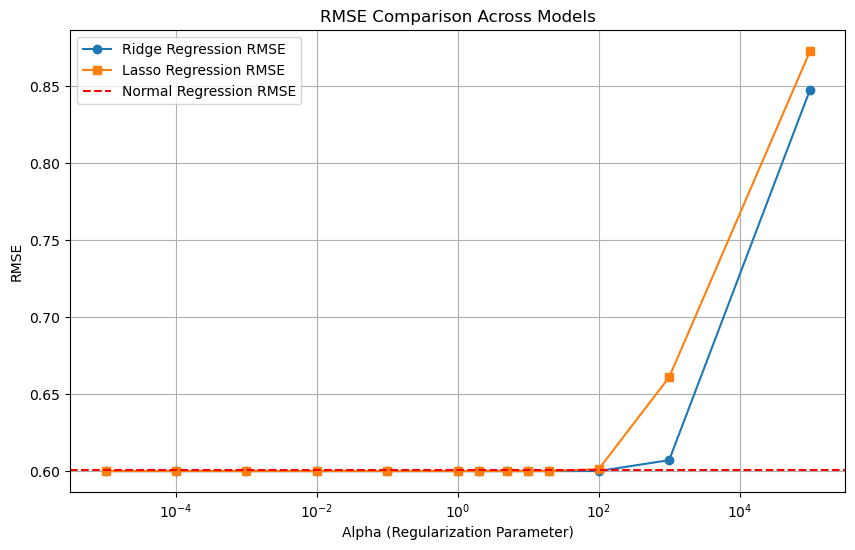

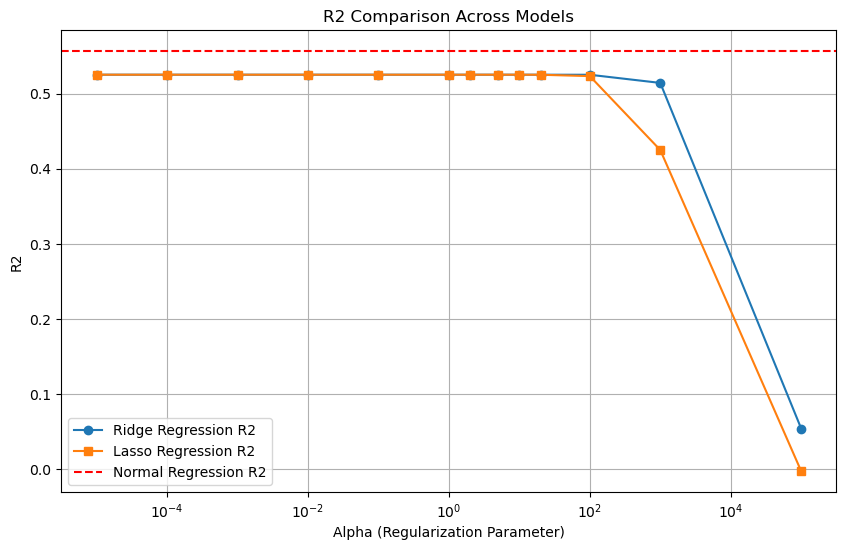

In [19]:
X = np.array([
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Number of ratings'],
    df_capstone_dropped_final['Received a pepper'],
    df_capstone_dropped_final['Female Professor'],
    df_capstone_dropped_final['Proportion of online class ratings']
]).T

y = np.array(df_capstone_dropped_final['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [20]:
[i.name for i in [df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Number of ratings'],
    df_capstone_dropped_final['Received a pepper'],
    df_capstone_dropped_final['Female Professor'],
    df_capstone_dropped_final['Proportion of online class ratings']]]

['Average Difficulty',
 'Number of ratings',
 'Received a pepper',
 'Female Professor',
 'Proportion of online class ratings']

In [21]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))

[0 3 2 5 4 1]
(array([ 3.93092892, -0.47342478,  0.02866962,  0.30287553, -0.04510353,
       -0.00814768]), 0.584302061268989, 0.5680017745550805)


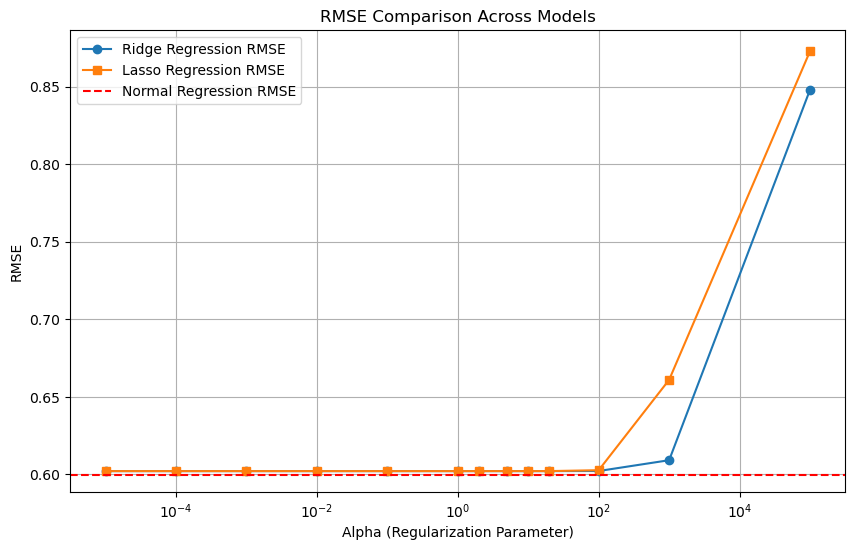

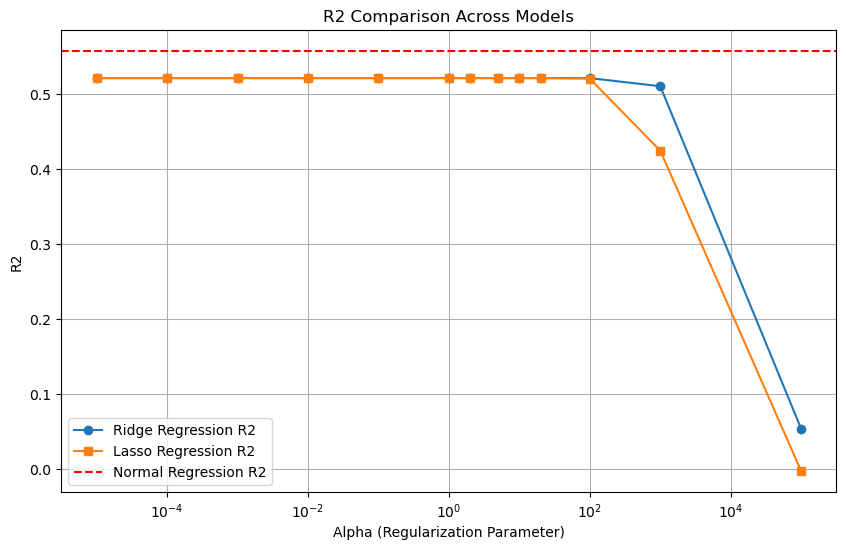

In [22]:
X = np.array([
    df_capstone_dropped_final['Average Difficulty'],
    df_capstone_dropped_final['Received a pepper'],
]).T

y = np.array(df_capstone_dropped_final['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [23]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))

[0 2 1]
(array([ 3.93092892, -0.4729102 ,  0.30400802]), 0.5850078025951724, 0.5669575779220706)


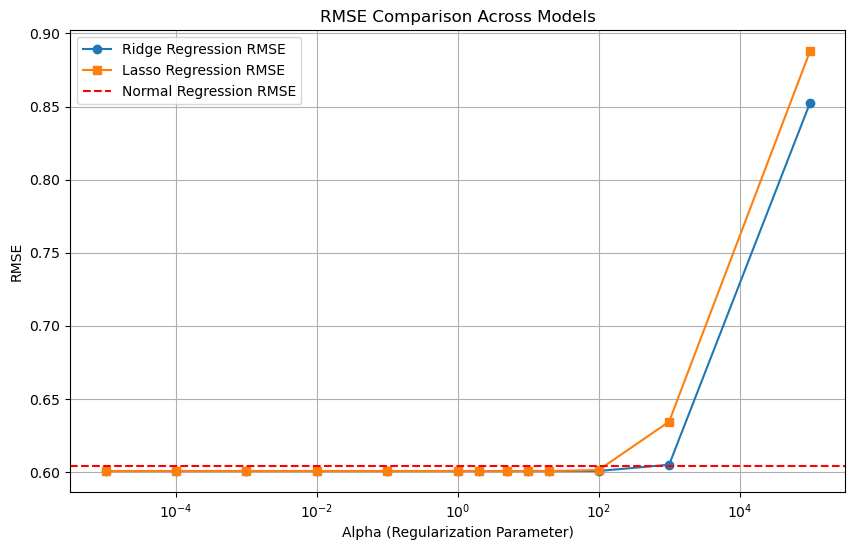

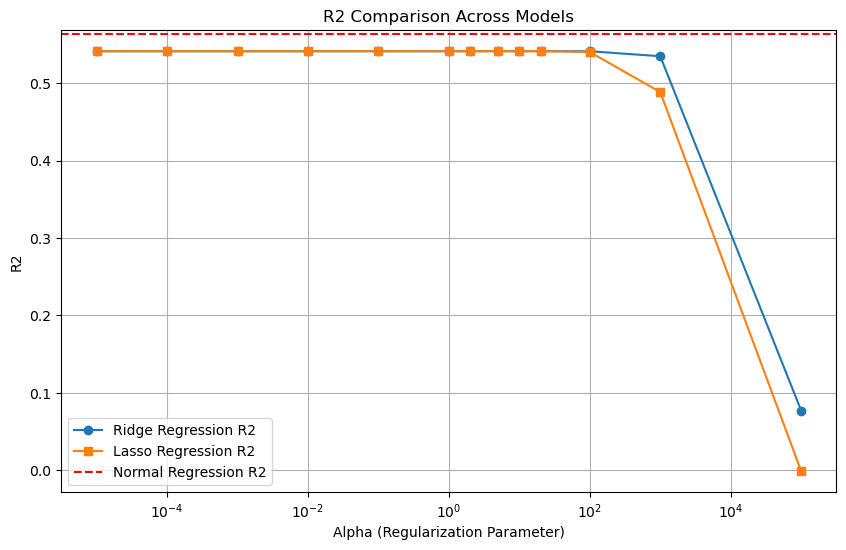

In [24]:
X = np.array([
    df_capstone_greater_than_10['Average Difficulty'],
    df_capstone_greater_than_10['Number of ratings'],
    df_capstone_greater_than_10['Received a pepper'],
    df_capstone_greater_than_10['Female Professor'],
    df_capstone_greater_than_10['Proportion of online class ratings'],
    df_capstone_greater_than_10['Male Professor'],
    df_capstone_greater_than_10['Number of ratings coming from online classes']
]).T

y = np.array(df_capstone_greater_than_10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [25]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))

[0 3 6 2 4 7 5 1]
(array([ 3.89192073, -0.48614938,  0.02612903,  0.31175563,  0.01505999,
       -0.0157395 ,  0.05506781,  0.0055976 ]), 0.6096306227481247, 0.5148385747200355)


In [26]:
tagsdf=pd.read_csv('./rmpCapstoneTags.csv', header=None)

In [27]:
Q8df=df_capstone[['Average Rating','Number of ratings']].join(tagsdf, how='inner')


In [28]:
Q8df.dropna(inplace=True)

In [29]:
Q8df

,Average Rating,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,5.0,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3.2,4.0,2,1,2,1,0,4,2,0,...,0,0,0,0,0,0,0,0,0,0
3,3.6,10.0,6,3,0,0,2,4,2,1,...,0,2,1,0,0,0,0,0,1,0
4,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.5,22.0,8,13,1,3,2,3,2,1,...,0,7,3,0,0,0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89885,3.9,4.0,2,0,0,3,0,1,0,1,...,0,0,0,0,0,1,1,0,0,0
89888,2.5,2.0,0,1,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
89889,4.5,2.0,1,1,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
89890,5.0,6.0,0,3,1,1,2,1,0,0,...,0,0,4,0,0,1,0,0,0,0


In [30]:
for i in Q8df.columns[2:]:
    Q8df[i] = Q8df[i].div(Q8df['Number of ratings'])

In [31]:
Q8df

,Average Rating,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,5.0,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.500000
2,3.2,4.0,0.500000,0.250000,0.500000,0.250000,0.000000,1.000000,0.500000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,3.6,10.0,0.600000,0.300000,0.000000,0.000000,0.200000,0.400000,0.200000,0.100000,...,0.0,0.200000,0.100000,0.0,0.0,0.000000,0.000000,0.0,0.100000,0.000000
4,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
5,3.5,22.0,0.363636,0.590909,0.045455,0.136364,0.090909,0.136364,0.090909,0.045455,...,0.0,0.318182,0.136364,0.0,0.0,0.000000,0.136364,0.0,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89885,3.9,4.0,0.500000,0.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.250000,...,0.0,0.000000,0.000000,0.0,0.0,0.250000,0.250000,0.0,0.000000,0.000000
89888,2.5,2.0,0.000000,0.500000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
89889,4.5,2.0,0.500000,0.500000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,...,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.500000,0.0,0.000000,0.000000
89890,5.0,6.0,0.000000,0.500000,0.166667,0.166667,0.333333,0.166667,0.000000,0.000000,...,0.0,0.000000,0.666667,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.000000


In [32]:
Q8dfgreater10=Q8df[Q8df['Number of ratings'] >= 10]

In [33]:
Q8dfgreater10

,Average Rating,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
3,3.6,10.0,0.600000,0.300000,0.000000,0.000000,0.200000,0.400000,0.200000,0.100000,...,0.00,0.200000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
5,3.5,22.0,0.363636,0.590909,0.045455,0.136364,0.090909,0.136364,0.090909,0.045455,...,0.00,0.318182,0.136364,0.000000,0.000000,0.000000,0.136364,0.000000,0.045455,0.136364
21,2.6,10.0,0.400000,0.300000,0.000000,0.000000,0.200000,0.000000,0.100000,0.100000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.500000,0.100000
25,4.3,16.0,0.375000,0.312500,0.250000,0.062500,0.062500,0.000000,0.000000,0.437500,...,0.00,0.000000,0.062500,0.000000,0.000000,0.125000,0.625000,0.000000,0.000000,0.062500
39,3.5,20.0,0.000000,0.050000,0.100000,0.100000,0.100000,0.100000,0.050000,0.100000,...,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.300000,0.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89841,4.2,11.0,0.181818,0.181818,0.272727,0.363636,0.090909,0.000000,0.090909,0.000000,...,0.00,0.090909,0.545455,0.000000,0.090909,0.272727,0.090909,0.000000,0.000000,0.000000
89855,4.0,11.0,0.000000,0.181818,0.090909,0.090909,0.636364,0.000000,0.000000,0.000000,...,0.00,0.090909,0.000000,0.000000,0.363636,0.090909,0.090909,0.000000,0.090909,0.181818
89866,4.4,14.0,0.285714,0.071429,0.071429,0.000000,0.071429,0.357143,0.214286,0.000000,...,0.00,0.214286,0.214286,0.214286,0.071429,0.285714,0.142857,0.214286,0.000000,0.071429
89875,2.8,16.0,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,...,0.00,0.125000,0.000000,0.375000,0.062500,0.000000,0.000000,0.000000,0.187500,0.187500


In [34]:
corrgreater40=Q8dfgreater10.corr()[Q8dfgreater10.corr()>0.42]
[i for i in list(corrgreater40[corrgreater40.notnull()].stack().index) if i[0]!=i[1]]

[('Average Rating', 1),
 ('Average Rating', 2),
 ('Average Rating', 7),
 ('Average Rating', 15),
 ('Average Rating', 16),
 (1, 'Average Rating'),
 (2, 'Average Rating'),
 (2, 7),
 (7, 'Average Rating'),
 (7, 2),
 (15, 'Average Rating'),
 (16, 'Average Rating')]

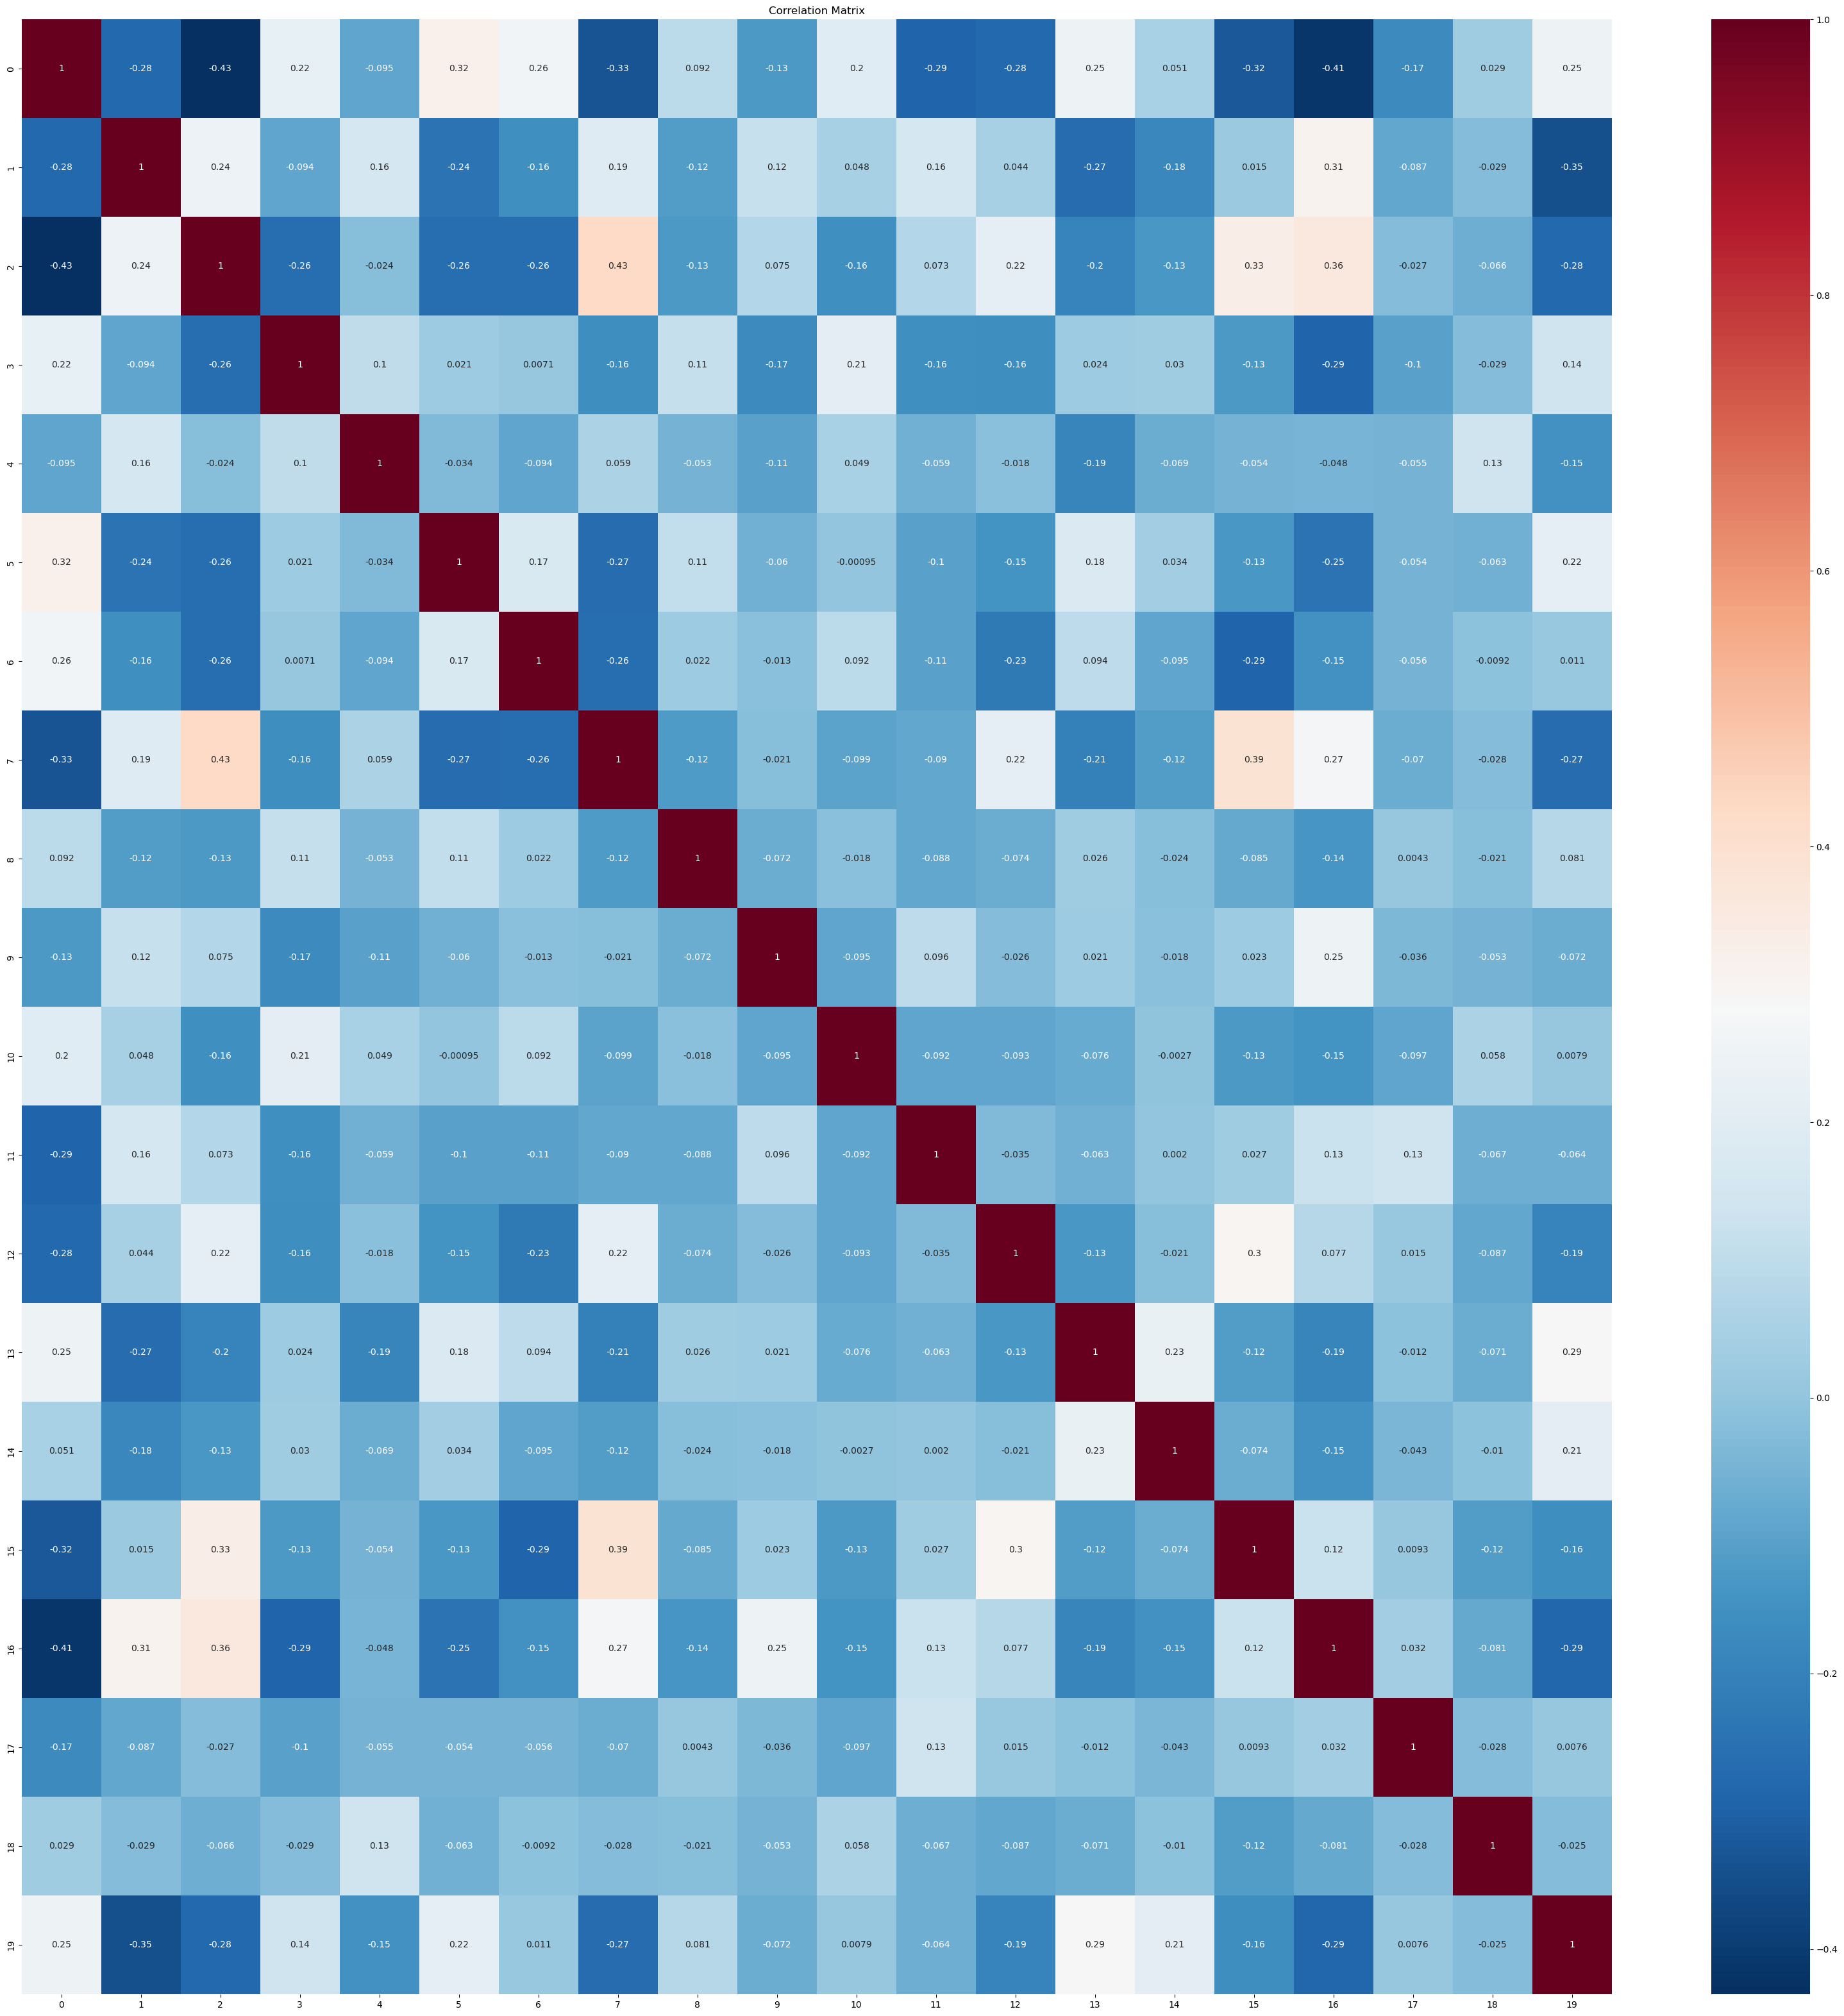

In [35]:
correlation_matrix = Q8dfgreater10.drop(columns=['Number of ratings','Average Rating']).corr()
plt.figure(figsize = (40,40))
sns.heatmap(correlation_matrix,cmap = "RdBu_r", annot=True)
plt.title('Correlation Matrix')
plt.show()


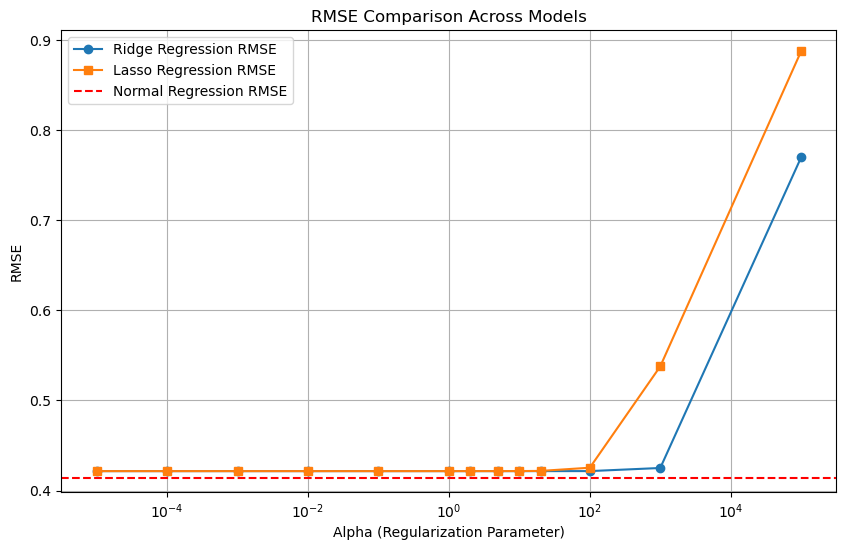

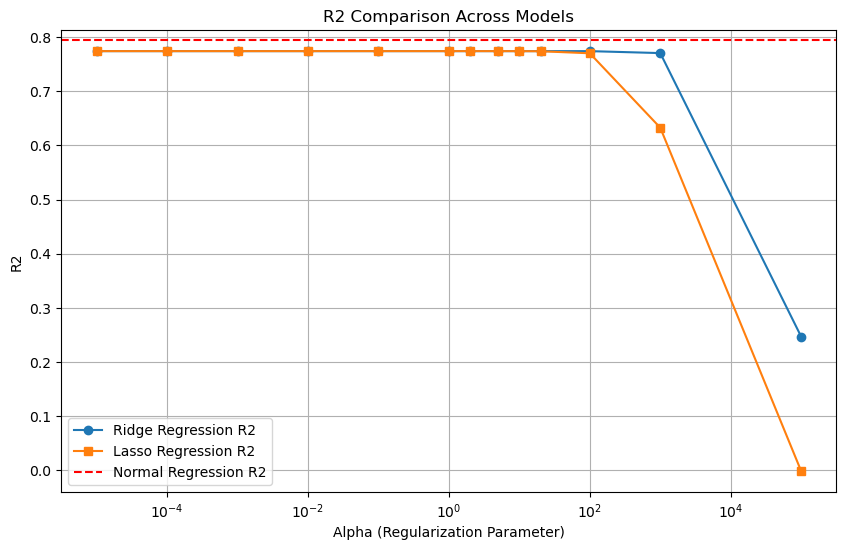

In [36]:
import numpy as np
from sklearn.model_selection import KFold  

X = np.array([
    Q8dfgreater10[0],
    Q8dfgreater10[1],
    Q8dfgreater10[2],
    Q8dfgreater10[3],
    Q8dfgreater10[4],
    Q8dfgreater10[5],
    Q8dfgreater10[6],
    Q8dfgreater10[7],
    Q8dfgreater10[8],
    Q8dfgreater10[9],
    Q8dfgreater10[10],
    Q8dfgreater10[11],
    Q8dfgreater10[12],
    Q8dfgreater10[13],
    Q8dfgreater10[14],
    Q8dfgreater10[15],
    Q8dfgreater10[16],
    Q8dfgreater10[17],
    Q8dfgreater10[18],
    Q8dfgreater10[19],
]).T

y = np.array(Q8dfgreater10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [37]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))

[ 0  2 16  3 17 12 13 18  5  8  6 10  4  9 19 15 11  7 14 20  1]
(array([ 3.89192073, -0.22036955,  0.19731039,  0.16069244,  0.01262664,
        0.07085632,  0.05932134, -0.03510021,  0.0668262 ,  0.01002024,
        0.05818639, -0.03462983,  0.12979173,  0.12762387, -0.04328246,
       -0.03006472,  0.18041539,  0.14799669,  0.0915715 , -0.01364599,
       -0.05790838]), 0.42829776585542356, 0.7605337392496383)


In [38]:
# Create correlation matrix
corr_matrix = Q8dfgreater10.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]

# Drop features 
Q8dfgreater10.drop(to_drop, axis=1)

,Average Rating,Number of ratings,3,4,5,6,8,9,10,11,12,13,14,17,18
3,3.6,10.0,0.000000,0.200000,0.400000,0.200000,0.0000,0.000000,0.00,0.200000,0.100000,0.000000,0.000000,0.000000,0.100000
5,3.5,22.0,0.136364,0.090909,0.136364,0.090909,0.0000,0.136364,0.00,0.318182,0.136364,0.000000,0.000000,0.000000,0.045455
21,2.6,10.0,0.000000,0.200000,0.000000,0.100000,0.0000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
25,4.3,16.0,0.062500,0.062500,0.000000,0.000000,0.0625,0.187500,0.00,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
39,3.5,20.0,0.100000,0.100000,0.100000,0.050000,0.1500,0.000000,0.05,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89841,4.2,11.0,0.363636,0.090909,0.000000,0.090909,0.0000,0.090909,0.00,0.090909,0.545455,0.000000,0.090909,0.000000,0.000000
89855,4.0,11.0,0.090909,0.636364,0.000000,0.000000,0.0000,0.363636,0.00,0.090909,0.000000,0.000000,0.363636,0.000000,0.090909
89866,4.4,14.0,0.000000,0.071429,0.357143,0.214286,0.0000,0.142857,0.00,0.214286,0.214286,0.214286,0.071429,0.214286,0.000000
89875,2.8,16.0,0.000000,0.062500,0.000000,0.000000,0.0000,0.125000,0.00,0.125000,0.000000,0.375000,0.062500,0.000000,0.187500


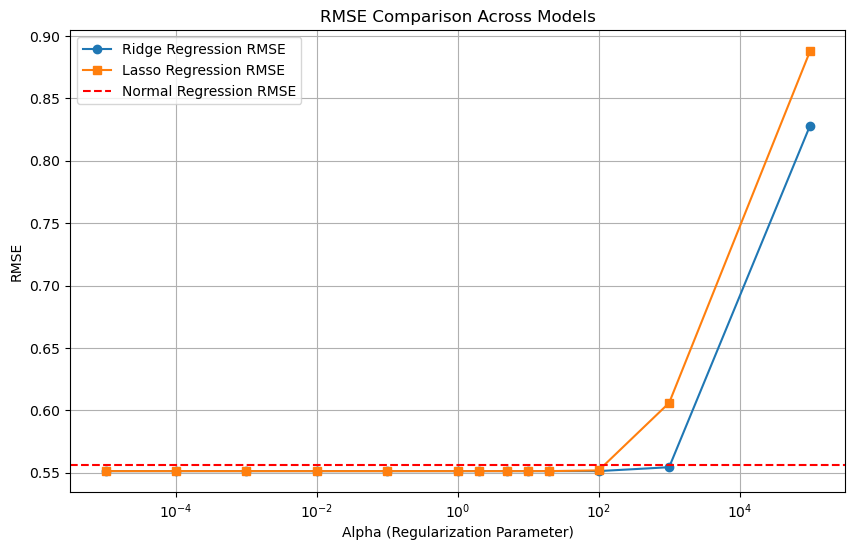

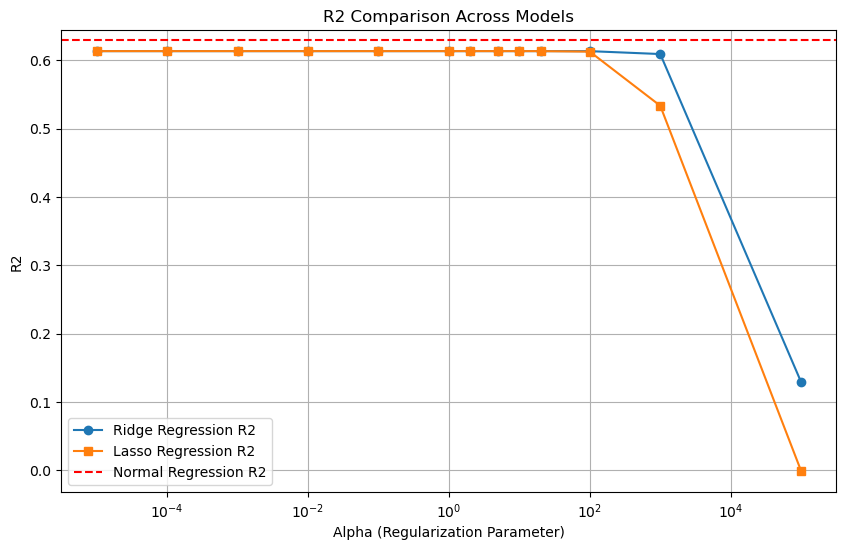

In [39]:
X = np.array([
    Q8dfgreater10[1],
    Q8dfgreater10[2],
    Q8dfgreater10[7],
    Q8dfgreater10[15],
    Q8dfgreater10[16]
]).T

y = np.array(Q8dfgreater10['Average Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [40]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0] 
indices = np.argsort(mybetas)[::-1] 
print(indices)  
print(getbetas(X_train,y_train,X_test,y_test))

[0 4 1 5 2 3]
(array([3.89192073, 0.27267552, 0.23583586, 0.0692236 , 0.27394206,
       0.23699102]), 0.5572969530912241, 0.5945605051435738)


#### 9. Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? Hint: Make sure to address collinearity concerns

In [41]:
Q9df=df_capstone[['Average Difficulty','Number of ratings']].join(tagsdf, how='inner')

In [42]:
Q9df.head(2)

,Average Difficulty,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,1.5,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Q9df.dropna(inplace=True)

In [44]:
Q9df.head(2)

,Average Difficulty,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,1.5,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3.0,4.0,2,1,2,1,0,4,2,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
for i in Q9df.columns[2:]:
    Q9df[i] = Q8df[i].div(Q8df['Number of ratings'])

In [46]:
Q9df.head(2)

,Average Difficulty,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,1.5,2.0,0.000,0.0000,0.000,0.0000,0.0,0.25,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
2,3.0,4.0,0.125,0.0625,0.125,0.0625,0.0,0.25,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [47]:
Q9dfgreater10=Q9df[Q8df['Number of ratings'] >= 10]

In [48]:
Q9dfgreater10.head(2)

,Average Difficulty,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
3,3.5,10.0,0.060000,0.03000,0.000000,0.000000,0.020000,0.040000,0.020000,0.010000,...,0.0,0.020000,0.010000,0.0,0.0,0.0,0.000000,0.0,0.010000,0.000000
5,3.3,22.0,0.016529,0.02686,0.002066,0.006198,0.004132,0.006198,0.004132,0.002066,...,0.0,0.014463,0.006198,0.0,0.0,0.0,0.006198,0.0,0.002066,0.006198


In [49]:
corrgreater40=Q9dfgreater10.corr()[Q9dfgreater10.corr()>0.30]
[i for i in list(corrgreater40[corrgreater40.notnull()].stack().index) if i[0]!=i[1]]

[('Average Difficulty', 0),
 ('Average Difficulty', 5),
 (0, 'Average Difficulty'),
 (0, 5),
 (1, 2),
 (1, 16),
 (2, 1),
 (2, 7),
 (2, 15),
 (2, 16),
 (5, 'Average Difficulty'),
 (5, 0),
 (7, 2),
 (7, 15),
 (7, 16),
 (12, 15),
 (15, 2),
 (15, 7),
 (15, 12),
 (16, 1),
 (16, 2),
 (16, 7)]

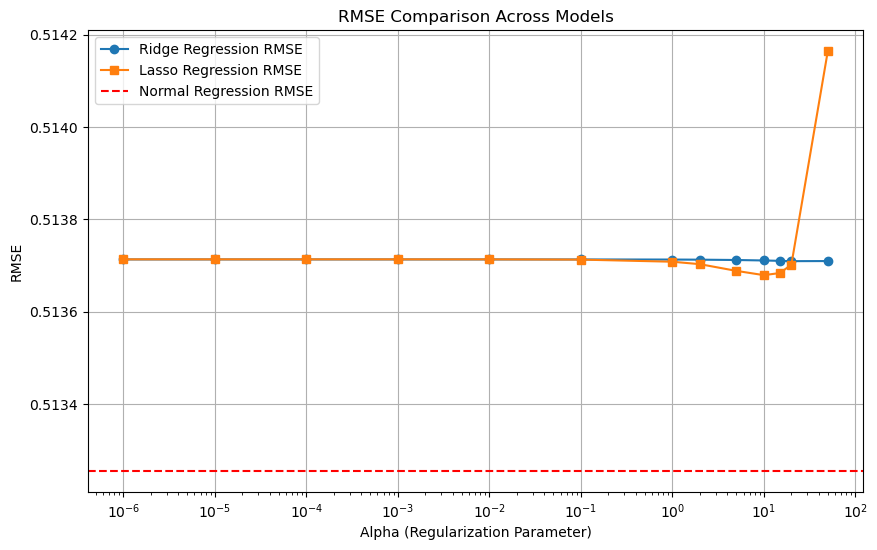

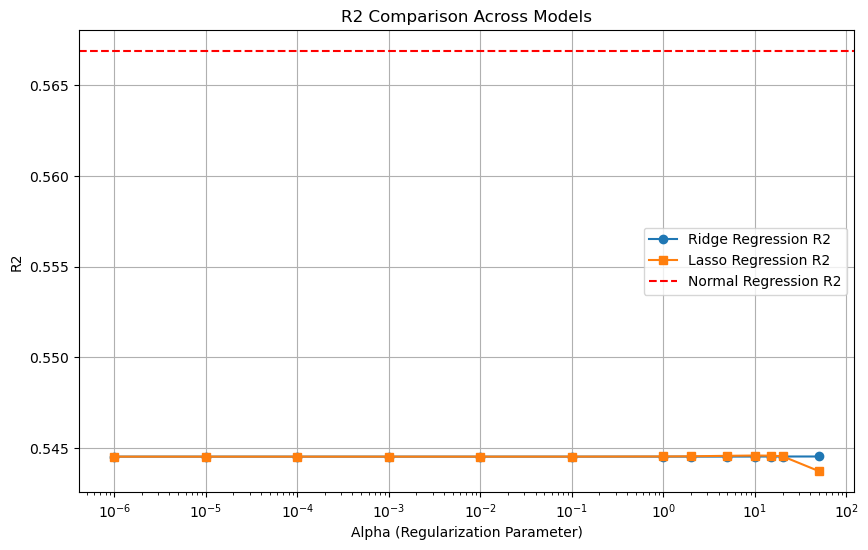

In [50]:
X = np.array([
    Q9dfgreater10[0],
    Q9dfgreater10[1],
    Q9dfgreater10[2],
    Q9dfgreater10[3],
    Q9dfgreater10[4],
    Q9dfgreater10[5],
    Q9dfgreater10[6],
    Q9dfgreater10[7],
    Q9dfgreater10[8],
    Q9dfgreater10[9],
    Q9dfgreater10[10],
    Q9dfgreater10[11],
    Q9dfgreater10[12],
    Q9dfgreater10[13],
    Q9dfgreater10[14],
    Q9dfgreater10[15],
    Q9dfgreater10[16],
    Q9dfgreater10[17],
    Q9dfgreater10[18],
    Q9dfgreater10[19],
]).T

y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


results=getKFresults(X_train,y_train,alphas=np.array([0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,15,20,50]))

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df,alphas=np.array([0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,5,10,15,20,50]))

In [51]:
mybetas=getbetaslasso(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(mybetas[indices]) 
print(getbetaslasso(X_train,y_train,X_test,y_test))

[ 0  1 14 10  7  4  6 20 11  9 16  8 19  5  2  3 15 17 18 13 12]
[ 2.96004827e+00  3.29975100e-01  1.05914165e-01  7.62844936e-02
  5.79493255e-02  5.19332619e-02  4.87982499e-02  1.04196756e-02
  0.00000000e+00 -2.22591963e-03 -6.40693239e-03 -1.59740736e-02
 -2.15184865e-02 -2.57287701e-02 -3.90005029e-02 -4.62329107e-02
 -5.03649701e-02 -7.01246629e-02 -7.57048578e-02 -9.42562425e-02
 -1.05290015e-01]
(array([ 2.96004827e+00,  3.29975100e-01, -3.90005029e-02, -4.62329107e-02,
        5.19332619e-02, -2.57287701e-02,  4.87982499e-02,  5.79493255e-02,
       -1.59740736e-02, -2.22591963e-03,  7.62844936e-02,  0.00000000e+00,
       -1.05290015e-01, -9.42562425e-02,  1.05914165e-01, -5.03649701e-02,
       -6.40693239e-03, -7.01246629e-02, -7.57048578e-02, -2.15184865e-02,
        1.04196756e-02]), 0.521137499911534, 0.5109168023932773)


In [52]:
mybetas=getbetaslasso(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)
print(indices)
print(mybetas[indices]) 
print(getbetaslasso(X_train,y_train,X_test,y_test))

[12 13 18 17 15  3  2  5 19  8 16  9 11 20  6  4  7 10 14  1  0]
[-1.05290015e-01 -9.42562425e-02 -7.57048578e-02 -7.01246629e-02
 -5.03649701e-02 -4.62329107e-02 -3.90005029e-02 -2.57287701e-02
 -2.15184865e-02 -1.59740736e-02 -6.40693239e-03 -2.22591963e-03
  0.00000000e+00  1.04196756e-02  4.87982499e-02  5.19332619e-02
  5.79493255e-02  7.62844936e-02  1.05914165e-01  3.29975100e-01
  2.96004827e+00]
(array([ 2.96004827e+00,  3.29975100e-01, -3.90005029e-02, -4.62329107e-02,
        5.19332619e-02, -2.57287701e-02,  4.87982499e-02,  5.79493255e-02,
       -1.59740736e-02, -2.22591963e-03,  7.62844936e-02,  0.00000000e+00,
       -1.05290015e-01, -9.42562425e-02,  1.05914165e-01, -5.03649701e-02,
       -6.40693239e-03, -7.01246629e-02, -7.57048578e-02, -2.15184865e-02,
        1.04196756e-02]), 0.521137499911534, 0.5109168023932773)


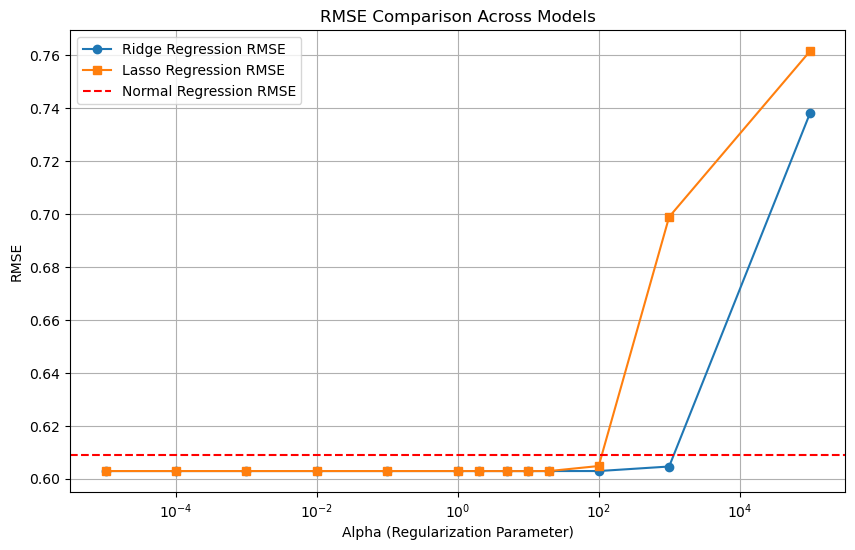

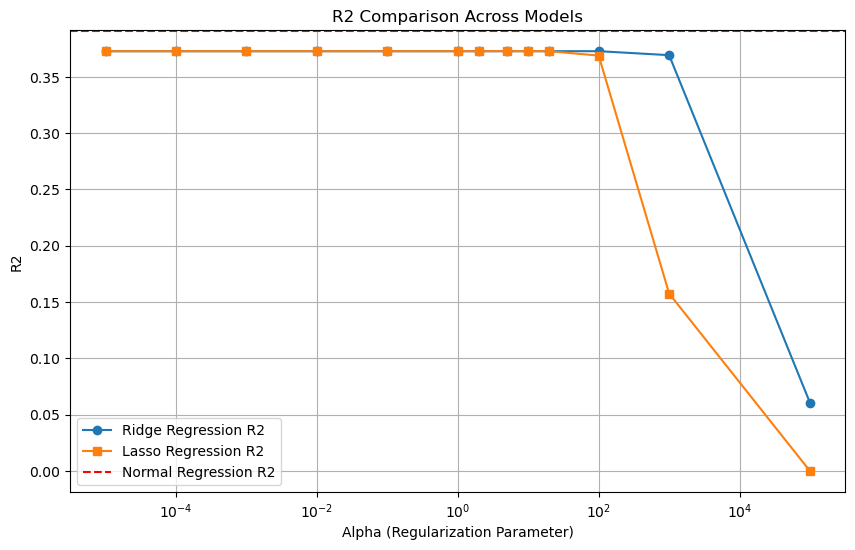

In [53]:
X = np.array([
    Q9dfgreater10[3],
    Q9dfgreater10[4],
    Q9dfgreater10[5],
    Q9dfgreater10[6],
    Q9dfgreater10[8],
    Q9dfgreater10[9],
    Q9dfgreater10[10],
    Q9dfgreater10[11],
    Q9dfgreater10[12],
    Q9dfgreater10[13],
    Q9dfgreater10[14],
    Q9dfgreater10[17],
    Q9dfgreater10[18],
]).T

y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [54]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(getbetas(X_train,y_train,X_test,y_test))

[ 0 10  3  4  1  7  6  5 13 11  2 12  9  8]
(array([ 2.96004827e+00,  1.20431505e-01, -6.01126539e-02,  1.53563996e-01,
        1.23896887e-01,  1.47673133e-02,  4.07545312e-02,  4.36035431e-02,
       -1.76989299e-01, -1.53767782e-01,  1.71215664e-01, -2.66852194e-02,
       -9.88465099e-02, -2.55347428e-03]), 0.6014816405317295, 0.34848736315195483)


In [55]:
Q9dfgreater10.corr()

,Average Difficulty,Number of ratings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
Average Difficulty,1.000000,-0.004543,0.628814,-0.235466,-0.340806,0.226230,-0.087488,0.300154,0.282746,-0.276084,...,0.129975,-0.271236,-0.296922,0.298937,0.019341,-0.232570,-0.318867,-0.191192,-0.006518,0.232945
Number of ratings,-0.004543,1.000000,-0.197960,-0.254502,-0.212696,-0.185317,-0.217705,-0.217675,-0.178477,-0.150523,...,-0.103644,-0.220387,-0.139705,-0.095460,-0.121215,-0.152976,-0.249025,-0.137034,-0.111723,-0.168310
0,0.628814,-0.197960,1.000000,-0.133910,-0.288229,0.256530,0.003446,0.363298,0.296874,-0.239046,...,0.222709,-0.170072,-0.198129,0.235799,0.091136,-0.226384,-0.259574,-0.101196,0.069880,0.272185
1,-0.235466,-0.254502,-0.133910,1.000000,0.315858,0.030493,0.240159,-0.092458,-0.030406,0.244685,...,0.084745,0.247109,0.120943,-0.175926,-0.089122,0.091457,0.387133,-0.014049,0.026806,-0.209478
2,-0.340806,-0.212696,-0.288229,0.315858,1.000000,-0.142722,0.071604,-0.132620,-0.149819,0.436527,...,-0.092902,0.155900,0.246780,-0.126588,-0.051906,0.334822,0.401924,0.030891,-0.004094,-0.165592
3,0.226230,-0.185317,0.256530,0.030493,-0.142722,1.000000,0.177780,0.093139,0.069367,-0.084112,...,0.239967,-0.050842,-0.098274,0.040893,0.067062,-0.055695,-0.148392,-0.040959,0.016516,0.181689
4,-0.087488,-0.217705,0.003446,0.240159,0.071604,0.177780,1.000000,0.066753,0.004323,0.112489,...,0.087036,0.054712,0.050318,-0.125098,0.000759,0.019476,0.084434,0.004483,0.176444,-0.058145
5,0.300154,-0.217675,0.363298,-0.092458,-0.132620,0.093139,0.066753,1.000000,0.220085,-0.176133,...,0.045719,0.003801,-0.079393,0.174337,0.075638,-0.060749,-0.107937,0.006165,-0.013542,0.253359
6,0.282746,-0.178477,0.296874,-0.030406,-0.149819,0.069367,0.004323,0.220085,1.000000,-0.174550,...,0.127307,-0.011712,-0.157527,0.102888,-0.045336,-0.211018,-0.034627,-0.008678,0.023367,0.058216
7,-0.276084,-0.150523,-0.239046,0.244685,0.436527,-0.084112,0.112489,-0.176133,-0.174550,1.000000,...,-0.064354,-0.010093,0.246910,-0.151803,-0.062772,0.376457,0.308115,-0.019532,0.014080,-0.184492


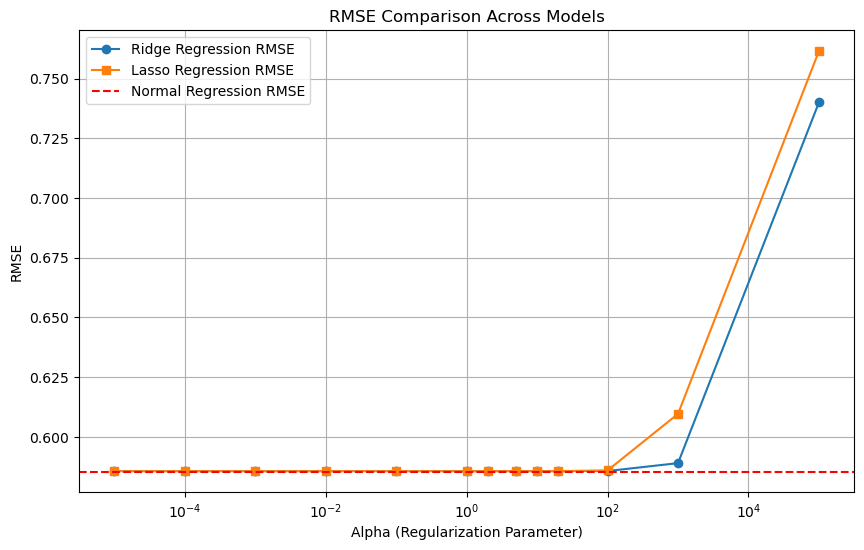

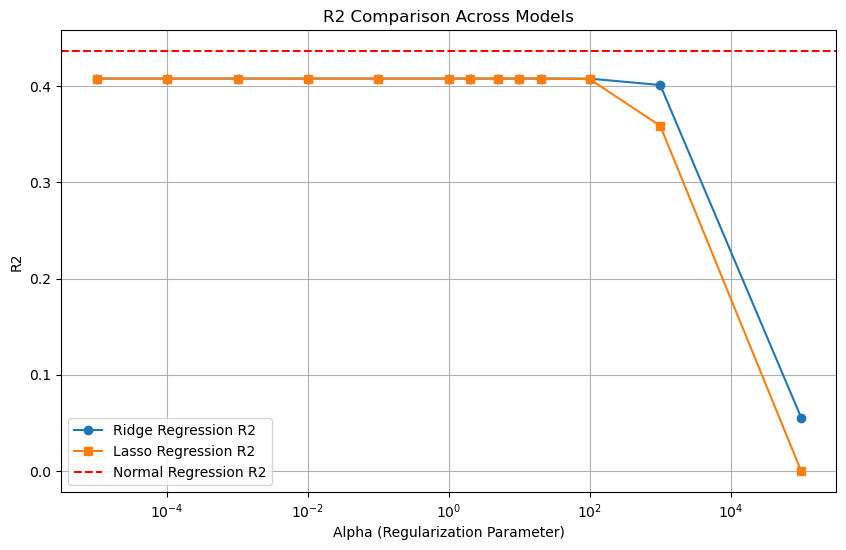

In [56]:
X = np.array([
    Q9dfgreater10[0],
    Q9dfgreater10[5],
]).T

y = np.array(Q9dfgreater10['Average Difficulty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

results=getKFresults(X_train,y_train)

results_df = pd.DataFrame(results, columns=['Model', 'Alpha', 'RMSE', 'R2'])

plot_results(results_df)

In [57]:
mybetas=getbetas(X_train,y_train,X_test,y_test)[0]
indices = np.argsort(mybetas)[::-1]
print(indices) 
print(getbetas(X_train,y_train,X_test,y_test))

[0 1 2]
(array([2.96004827, 0.45967651, 0.06505184]), 0.5922710952624792, 0.3682879386879454)
